# Exercises - Churn Prediction

## Import Libraries

In [2]:
from __future__ import division
import pandas as pd
import numpy as np
from numpy import interp
import json
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from collections import defaultdict
%matplotlib inline
warnings.filterwarnings('ignore')

## Import Data

In [3]:
churn_df = pd.read_csv('./exercises-churn-prediction-dataset.csv')

## Data Preparation

In [4]:
col_names = churn_df.columns.tolist()
print("Column names:\n")
for j in col_names:
    print(j)
to_show = col_names[:6] + col_names[-6:]
print("\nSample data:")
churn_df[to_show].head(6)

Column names:

State
Account Length
Area Code
Phone
Int'l Plan
VMail Plan
VMail Message
Day Mins
Day Calls
Day Charge
Eve Mins
Eve Calls
Eve Charge
Night Mins
Night Calls
Night Charge
Intl Mins
Intl Calls
Intl Charge
CustServ Calls
Churn?

Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


In [5]:
# Isolate target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

In [6]:
# We don't need these columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

In [7]:
# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

In [8]:
# Pull out features for future use
features = churn_feat_space.columns
print(features)

Index(['Account Length', 'Int'l Plan', 'VMail Plan', 'VMail Message',
       'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls',
       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins',
       'Intl Calls', 'Intl Charge', 'CustServ Calls'],
      dtype='object')


In [9]:
X = churn_feat_space
# This is important
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


## Model Training

In [10]:
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(n_splits=3,shuffle=True)
    y_pred = y.copy()
    # Iterate through folds
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred)

In [11]:
print("Logistic Regression:")
print("%.3f" % accuracy(y, run_cv(X,y,LR)))
print("\nGradient Boosting Classifier")
print("%.3f" % accuracy(y, run_cv(X,y,GBC)))
print("\nSupport vector machines:")
print("%.3f" % accuracy(y, run_cv(X,y,SVC)))
print("\nRandom forest:")
print("%.3f" % accuracy(y, run_cv(X,y,RF)))

Logistic Regression:
0.862

Gradient Boosting Classifier
0.948

Support vector machines:
0.915

Random forest:
0.953


In [12]:
def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

[[2817   33]
 [ 244  239]]


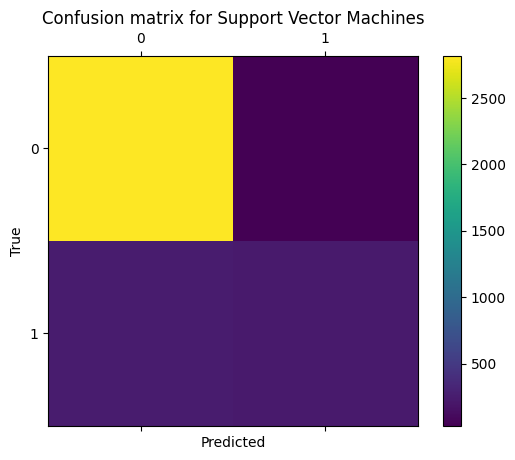

[[2829   21]
 [ 132  351]]


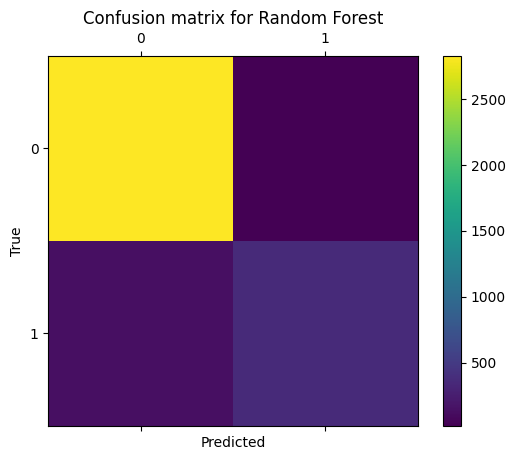

[[2812   38]
 [ 131  352]]


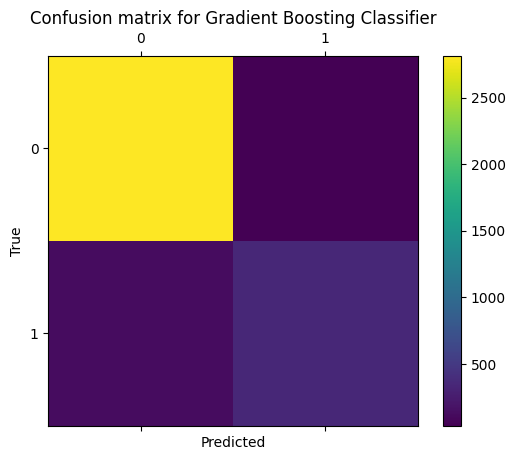

[[2771   79]
 [ 386   97]]


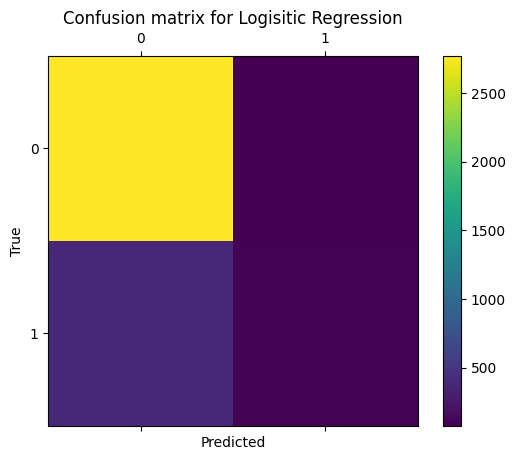

In [13]:
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "Support Vector Machines", confusion_matrix(y,run_cv(X,y,SVC)) ),
    ( "Random Forest", confusion_matrix(y,run_cv(X,y,RF)) ),
    ( "Gradient Boosting Classifier", confusion_matrix(y,run_cv(X,y,GBC)) ),
    ( "Logisitic Regression", confusion_matrix(y,run_cv(X,y,LR)) )
]

%matplotlib inline
draw_confusion_matrices(confusion_matrices,class_names)

In [14]:
def plot_roc(X, y, clf_class, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= kf.get_n_splits(X)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Support vector machines:


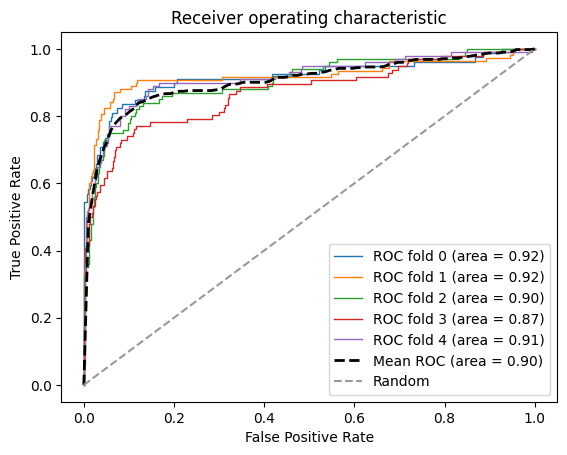

Random forests:


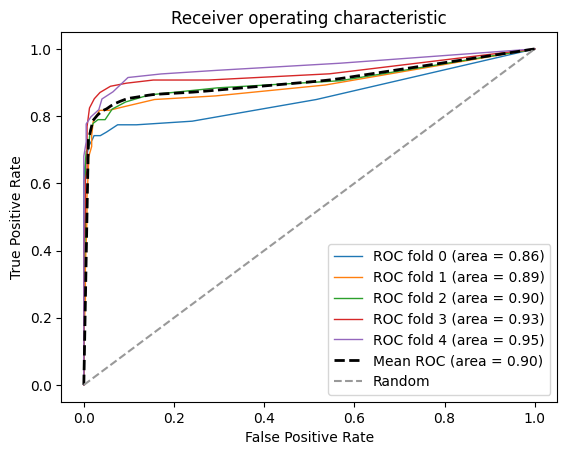

Gradient Boosting Classifier:


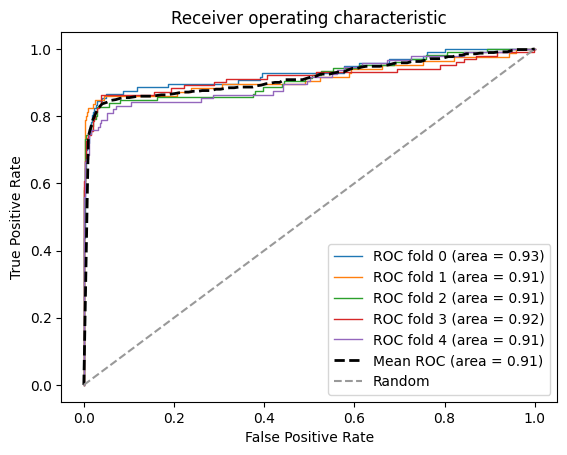

In [15]:
print("Support vector machines:")
plot_roc(X,y,SVC,probability=True)

print("Random forests:")
plot_roc(X,y,RF,n_estimators=18)

print("Gradient Boosting Classifier:")
plot_roc(X,y,GBC)

## Feature Importance Analysis

Feature ranking:
1. Account Length (0.140316)
2. Int'l Plan (0.134565)
3. VMail Plan (0.072801)
4. VMail Message (0.067763)
5. Day Mins (0.065743)
6. Day Calls (0.033964)
7. Day Charge (0.032349)
8. Eve Mins (0.032049)
9. Eve Calls (0.026533)
10. Eve Charge (0.023548)


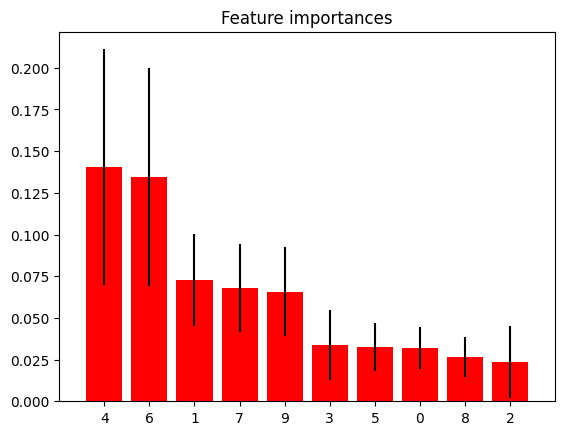

In [16]:
train_index,test_index = train_test_split(churn_df.index)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])

importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

In [17]:
def run_prob_cv(X, y, clf_class, roc=False, **kwargs):
    kf = KFold(n_splits=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
    return y_prob

In [18]:
# Use 10 estimators so predictions are all multiples of 0.1
pred_prob = run_prob_cv(X, y, RF, n_estimators=10)
pred_churn = pred_prob[:,1]
is_churn = y == 1

# Number of times a predicted probability is assigned to an observation
counts = pd.value_counts(pred_churn)
counts[:]

0.0    1770
0.1     692
0.2     252
0.3     125
0.4      82
0.7      81
0.8      75
0.6      70
0.9      65
1.0      61
0.5      60
dtype: int64

In [19]:
true_prob = defaultdict(float)

# calculate true probabilities
for prob in counts.index:
    true_prob[prob] = np.mean(is_churn[pred_churn == prob])
true_prob = pd.Series(true_prob)

# pandas-fu
counts = pd.concat([counts,true_prob], axis=1).reset_index()
counts.columns = ['pred_prob', 'count', 'true_prob']
counts

,pred_prob,count,true_prob
0,0.0,1770,0.025424
1,0.1,692,0.028902
2,0.2,252,0.059524
3,0.3,125,0.144000
4,0.4,82,0.268293
5,0.7,81,0.901235
6,0.8,75,0.986667
7,0.6,70,0.828571
8,0.9,65,1.000000
9,1.0,61,1.000000


In [20]:
"""

Measurements inspired by Philip Tetlock's "Expert Political Judgment"

Equations take from Yaniv, Yates, & Smith (1991):
  "Measures of Descrimination Skill in Probabilistic Judgement"

"""


def calibration(prob,outcome,n_bins=10):
    """Calibration measurement for a set of predictions.

    When predicting events at a given probability, how far is frequency
    of positive outcomes from that probability?
    NOTE: Lower scores are better

    prob: array_like, float
        Probability estimates for a set of events

    outcome: array_like, bool
        If event predicted occurred

    n_bins: int
        Number of judgement categories to prefrom calculation over.
        Prediction are binned based on probability, since "descrete" 
        probabilities aren't required. 

    """
    prob = np.array(prob)
    outcome = np.array(outcome)

    c = 0.0
    # Construct bins
    judgement_bins = np.arange(n_bins + 1) / n_bins
    # Which bin is each prediction in?
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        # Is event in bin
        in_bin = bin_num == j_bin
        # Predicted probability taken as average of preds in bin
        predicted_prob = np.mean(prob[in_bin])
        # How often did events in this bin actually happen?
        true_bin_prob = np.mean(outcome[in_bin])
        # Squared distance between predicted and true times num of obs
        c += np.sum(in_bin) * ((predicted_prob - true_bin_prob) ** 2)
    return c / len(prob)

def discrimination(prob,outcome,n_bins=10):
    """Discrimination measurement for a set of predictions.

    For each judgement category, how far from the base probability
    is the true frequency of that bin?
    NOTE: High scores are better

    prob: array_like, float
        Probability estimates for a set of events

    outcome: array_like, bool
        If event predicted occurred

    n_bins: int
        Number of judgement categories to prefrom calculation over.
        Prediction are binned based on probability, since "descrete" 
        probabilities aren't required. 

    """
    prob = np.array(prob)
    outcome = np.array(outcome)

    d = 0.0
    # Base frequency of outcomes
    base_prob = np.mean(outcome)
    # Construct bins
    judgement_bins = np.arange(n_bins + 1) / n_bins
    # Which bin is each prediction in?
    bin_num = np.digitize(prob,judgement_bins)
    for j_bin in np.unique(bin_num):
        in_bin = bin_num == j_bin
        true_bin_prob = np.mean(outcome[in_bin])
        # Squared distance between true and base times num of obs
        d += np.sum(in_bin) * ((true_bin_prob - base_prob) ** 2)
    return d / len(prob)

In [21]:
def print_measurements(pred_prob):
    churn_prob, is_churn = pred_prob[:,1], y == 1
    print("  %-20s %.4f" % ("Calibration Error", calibration(churn_prob, is_churn)))
    print("  %-20s %.4f" % ("Discrimination", discrimination(churn_prob,is_churn)))
    print("Note -- Lower calibration is better, higher discrimination is better")

In [22]:
print("Support vector machines:")
print_measurements(run_prob_cv(X,y,SVC,probability=True))

print("\nRandom forests:")
print_measurements(run_prob_cv(X,y,RF,n_estimators=18))

print("\nGradient Boosting Classifier:")
print_measurements(run_prob_cv(X,y,GBC))

print("\nRandom Forest:")
print_measurements(run_prob_cv(X,y,RF))

Support vector machines:
  Calibration Error    0.0007
  Discrimination       0.0655
Note -- Lower calibration is better, higher discrimination is better

Random forests:
  Calibration Error    0.0056
  Discrimination       0.0811
Note -- Lower calibration is better, higher discrimination is better

Gradient Boosting Classifier:
  Calibration Error    0.0015
  Discrimination       0.0833
Note -- Lower calibration is better, higher discrimination is better

Random Forest:
  Calibration Error    0.0061
  Discrimination       0.0862
Note -- Lower calibration is better, higher discrimination is better
